In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import plotly.express as px
from scipy.interpolate import BSpline
import plotly.graph_objects as go
import torch.nn.functional as F
import math

# MultiKAN Implemetation

## Network Layer

In [2]:
class KANLayer(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size # grid spacing

        ############################################################
        # torch.arange(-spline_order, grid_size + spline_order + 1)
        ############################################################
        # 1. Boundary Handling:
        # • B-spline basis functions are defined over multiple intervals (knots), 
        #   and the number of intervals is determined by the spline order. 
        #   For example, a cubic B-spline (order 3) requires at least four grid points (knots) 
        #   to define a single basis function.
        # • Near the edges of the input domain (e.g., near the first or last grid point in grid_size), 
        #   the basis functions would normally extend beyond the defined domain if no extra points 
        #   were included. This extension ensures that the spline basis functions are properly defined 
        #   even at the boundaries.

        # 2. Smoothness and Accuracy:
        # • Including extra grid points ensures that the B-spline basis functions remain smooth 
        #   and accurate across the entire domain, including at the boundaries. Without these 
        #   additional points, the basis functions would be truncated at the edges, leading to 
        #   a loss of smoothness and potential inaccuracies in the spline approximation.

        # 3. Support for All Basis Functions:
        # • Each B-spline basis function has a support that typically spans spline_order + 1 intervals 
        #   (for a B-spline of order spline_order). By extending the grid, you ensure that every basis 
        #   function, even those near the boundaries, has the full support it needs for accurate evaluation.
        ############################################################
        #torch.arange(...) * h + grid_range[0]
        ############################################################
        # 1. Aligning the Grid with the Input Space:
        # • The sequence generated by torch.arange() is just a set of index positions, 
        #   not actual values in the input space. These indices need to be converted into 
        #   grid points that reflect the real positions where B-spline basis functions will be evaluated.
        # • The multiplication by h ensures that the grid points are spaced correctly 
        #   according to the desired resolution of the grid.
        # • The addition of grid_range[0] ensures that the grid starts at the correct 
        #   position in the input space.

        # 2. Ensuring Proper Placement of B-Spline Knots:
        # • B-splines are sensitive to the placement of knots (grid points), as they determine 
        #   where each basis function is non-zero and how the spline interacts with the data. 
        #   Properly scaling and shifting the grid is crucial for accurately modeling the input data.
        # • By scaling and shifting the grid, you ensure that the B-spline knots are placed exactly 
        #   where they need to be to cover the desired range of the input space, including at the boundaries.
        ############################################################
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1) #Expands the grid tensor so that each input feature (or dimension) has an identical grid.
            .contiguous() #contiguos() makes a copy of the tensor such that the memory is contiguous
        )
        self.register_buffer("grid", grid) # buffers are tensors that are not updated during training

        #base functions weights
        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        #spline weights
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        self.scale_noise = scale_noise #Adding a small amount of noise to the initialization of B-spline weights can help prevent the network from learning trivial or overly smooth solutions
        self.scale_base = scale_base # Scaling the base weights by a factor of scale_base can help control the overall magnitude of the output of the layer.  If these weights are too large or too small, the network might either overfit or fail to learn effectively. 
        self.scale_spline = scale_spline 
        self.grid_eps = grid_eps # Controlls the blending between the adaptive and uniform grid
        
        self.initialize_params()

    def initialize_params(self):
        # • The parameter 'a' controls the scaling of the distribution. 
        #   Here, it’s scaled by 'math.sqrt(5) * self.scale_base'.
        # • 'math.sqrt(5)': This is a common scaling factor in Kaiming initialization 
        #   to account for the variance of the input. It’s derived from considerations 
        #   about the variance of the output in relation to the variance of the input.
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad(): #disables gradient tracking, which is useful when you’re only updating the values of tensors manually
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2 #centers the random values around 0
                )
                * self.scale_noise
                / self.grid_size #normalizes the noise based on the size of the grid, ensuring that the noise magnitude is inversely proportional to the grid size
            )

            #	This directly copies data into the spline_weight tensor
            self.spline_weight.data.copy_(
                self.scale_spline 
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order], #sliced portion of the transposed grid, likely excluding the boundary points not necessary for spline calculations
                    noise,
                )
            )


    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features # x should be a 2D tensor where the second dimension matches self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features) #y should have a shape that matches (batch_size, in_features, out_features), ensuring consistency between the input and output data.

        #System Matrix
        # Evaluate the B-spline bases at the input points and transpose the result to have a system of linear equations 
        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)

        #Output Matrix
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)

        #Solve the system of linear equations to find the coefficients of the curve
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)

        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()
    

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        # Retrieve the grid points (knots) for the B-spline bases
        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)

        # Add extra dimensions to the input tensor for broadcasting
        x = x.unsqueeze(-1)

        ######################################################################
        # Compute the B-spline bases using the Cox-de Boor recursion formula #
        ######################################################################
        #Computes the initial B-spline basis functions for the first degree (piecewise constant functions)
        # • grid[:, :-1] and grid[:, 1:]: These are slices of the grid tensor, representing the intervals between consecutive grid points.
        # • (x >= grid[:, :-1]) & (x < grid[:, 1:]): This creates a boolean mask that identifies where each value in x falls within each interval defined by the grid points.
        # • .to(x.dtype): Converts the boolean mask to the same data type as x, resulting in a tensor of 1s and 0s, where 1 indicates that x falls within the corresponding interval.
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)

        #Iteratively compute the higher-degree B-spline basis functions
        # • k: The loop variable k corresponds to the degree of the B-spline basis functions being calculated in each iteration.
        # • First Term:
        #   • (x - grid[:, : -(k + 1)]): Computes the difference between x and the start of the interval for the current basis function.
        #   • (grid[:, k:-1] - grid[:, : -(k + 1)]): Computes the length of the interval over which the basis function is non-zero.
        #   • bases[:, :, :-1]: Selects the basis functions computed in the previous step.
        # • Second Term:
        #   • (grid[:, k + 1 :] - x): Computes the difference between the end of the interval and x.
        #   • (grid[:, k + 1 :] - grid[:, 1:(-k)]): Computes the length of the next interval.
        #   • bases[:, :, 1:]: Selects the basis functions from the next interval computed in the previous step.
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()
    
    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        """
        Dynamically updates the grid points (knots) used in B-spline computations based on the 
        distribution of the input data. This method also recalculates the spline weights to 
        match the new grid, ensuring that the B-spline basis functions accurately model the 
        input-output relationship.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            margin (float): A small margin added to the grid's start and end to ensure the grid 
                            extends slightly beyond the input data range. Default is 0.01.
        
        Returns:
            None: The function updates the grid and spline weights in place.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        #Computes the B-spline basis functions for the input x
        splines = self.b_splines(x)  # (batch, in, coeff) where coeff = grid_size + spline_order is the number of coefficients

        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        # • Range Calculation: The expression (x_sorted[-1] - x_sorted[0]) computes the range of the data for each feature.
        # • Adding Margin: The + 2 * margin term extends the range slightly at both ends, ensuring that the grid points 
        #       are not exactly at the extreme ends of the data but cover a slightly larger area. This can be useful for 
        #       handling edge cases where new data might slightly exceed the current observed range.
        # • Step Size Calculation: Dividing this extended range by self.grid_size calculates the step size (uniform_step) 
        #       for the uniform grid. This step size determines the spacing between consecutive grid points.
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size

        # calculate the uniform grid points
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin #shift for the extended range
        )

        # blend the uniform grid with the adaptive grid
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive

        # extend the grid with the spline order
        grid = torch.concatenate(
            [
                # • grid[:1]: This selects the first grid point in the uniform grid and shifts it.
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid, # the original blended grid
                # • grid[-1:]: This selects the last grid point in the uniform grid and shifts it.
                grid[-1:] 
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0, # concatenates the three tensors along the first dimension
        )

        # update the grid and spline weights
        self.grid.copy_(grid.T)
        #recalculate the spline weights based on the new grid
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        A simplified version of the original L1 regularization as stated in the
        paper. 

        The L1 regularization is now computed as mean absolute value of the spline
        weights.
        """
        #  Computes the absolute value of each element in the spline_weight tensor and 
        #  averages the results across the last dimension 
        l1 = self.spline_weight.abs().mean(-1)

        # sums all the values in l1 to produce a single scalar value representing the total L1 regularization (over all features and grid points)
        # Encourages sparsity in the spline weights, which can help prevent overfitting and improve generalization.
        regularization_loss_activation = l1.sum()

        # compute the entropy regularization term
        # create a probability distribution p, where each element represents the proportion of the total L1 regularization contributed by a specific spline weight
        p = l1 / regularization_loss_activation

        # compute the entropy
        # • p * p.log(): Calculates the entropy of the distribution p. Entropy measures the uncertainty 
        #   or disorder of the distribution. In this context, lower entropy would mean that the 
        #   regularization is dominated by fewer weights, encouraging sparsity.
        # • -torch.sum(p * p.log()): Summing the negative entropy across all features provides a scalar 
        #   value, regularization_loss_entropy, representing the entropy penalty. Higher entropy values 
        #   penalize more spread-out distributions of regularization, encouraging the model to focus 
        #   on fewer non-zero weights.
        regularization_loss_entropy = -torch.sum(p * p.log())

        # the regularization terms (scaled by the respective regularization coefficients) are combined to produce the final regularization loss
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )
    
    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        # Compute the output of the base function 
        base_output = F.linear(nn.SiLU()(x), self.base_weight)

        # Compute the output of the spline function
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.spline_weight.view(self.out_features, -1),
        )

        return base_output + spline_output



## KAN Model

In [3]:
class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()

        # Create the hidden layers of the network
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLayer(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            # Update the grid if necessary before passing the input through the layer
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        # compute the total regularization loss by summing the regularization losses of all layers
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# Testing the Model

## Function Fitting

In [4]:
# create Function
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 2)

# plot the function with plotly
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
X, Y = torch.meshgrid(x, y)
Z = f(torch.stack([X.flatten(), Y.flatten()], dim=1)).reshape(X.shape)

fig = go.Figure(data=[go.Surface(z=Z.cpu().numpy(), x=X.cpu().numpy(), y=Y.cpu().numpy())])
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.5)))
fig.show()


/Users/edoardotavassi/Documents/coding_projects/heart/.venv/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# Create data
X = torch.rand(1000, 2) * 2 - 1  # 1000 samples, 2 features
y = f(X)  # Pass X (not x) to the function
# create the model
model = KAN([2, 5, 1, 1], grid_size=20, spline_order=4, grid_range=[-10, 10])

# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the loss function
loss_fn = torch.nn.MSELoss()

# train the model
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(X, update_grid=False)
    loss = loss_fn(y_pred, y)
    loss += model.regularization_loss()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")





Epoch 0, Loss 8.513479232788086
Epoch 100, Loss 5.0329813957214355
Epoch 200, Loss 4.393273830413818
Epoch 300, Loss 3.522557020187378
Epoch 400, Loss 2.5355143547058105
Epoch 500, Loss 1.9372179508209229
Epoch 600, Loss 1.669442892074585
Epoch 700, Loss 1.5303651094436646
Epoch 800, Loss 1.4688619375228882
Epoch 900, Loss 1.4234296083450317
Epoch 1000, Loss 1.3906266689300537
Epoch 1100, Loss 1.3685433864593506
Epoch 1200, Loss 1.3502674102783203
Epoch 1300, Loss 1.3337186574935913
Epoch 1400, Loss 1.3125102519989014
Epoch 1500, Loss 1.2963922023773193
Epoch 1600, Loss 1.2806551456451416
Epoch 1700, Loss 1.2844231128692627
Epoch 1800, Loss 1.2594213485717773
Epoch 1900, Loss 1.2350261211395264
Epoch 2000, Loss 1.2168971300125122
Epoch 2100, Loss 1.1926215887069702
Epoch 2200, Loss 1.1669695377349854
Epoch 2300, Loss 1.1402394771575928
Epoch 2400, Loss 1.0895178318023682
Epoch 2500, Loss 1.025886058807373
Epoch 2600, Loss 0.9515482187271118
Epoch 2700, Loss 0.898643434047699
Epoch 2800

In [6]:
# plot the model predictions and the true function with plotly with two different colors
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
X, Y = torch.meshgrid(x, y)

# Compute model predictions over the grid
Z = model.forward(torch.stack([X.flatten(), Y.flatten()], dim=1)).reshape(X.shape)

# Compute the true function values over the grid
Z_f = f(torch.stack([X.flatten(), Y.flatten()], dim=1)).reshape(X.shape)

# Create a Plotly figure
fig = go.Figure()

# Add a surface plot for the model predictions
fig.add_trace(go.Surface(z=Z.cpu().detach().numpy(), 
                         x=X.cpu().numpy(), 
                         y=Y.cpu().numpy(), 
                         name="Model Prediction", 
                         colorscale="Viridis"))

# Add a surface plot for the true function
fig.add_trace(go.Surface(z=Z_f.cpu().detach().numpy(), 
                         x=X.cpu().numpy(), 
                         y=Y.cpu().numpy(), 
                         name="True Function", 
                         colorscale="Cividis", 
                         opacity=0.6))

# Update the layout for better visualization
fig.update_layout(
    title="Model Predictions vs. True Function",
    scene=dict(
        xaxis_title="X Axis",
        yaxis_title="Y Axis",
        zaxis_title="Function Value",
        aspectratio=dict(x=1, y=1, z=0.5)
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True
)

# Show the plot
fig.show()





# Apply to our dataset

In [7]:
from sklearn.model_selection import train_test_split
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')

# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from torch.utils.data import DataLoader, TensorDataset
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [53]:
# Create the model
model = KAN([27,10,1, 1], grid_size=100, spline_order=2)

# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Create the loss function
loss_fn = nn.BCEWithLogitsLoss()


# Train the model with validation
losses_train = []

for epoch in range(500):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch, update_grid=False)
        loss = loss_fn(y_pred.flatten(), y_batch)
        #loss += model.regularization_loss()
        loss.backward()
        optimizer.step()
        losses_train.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {losses_train[-1]}")

#plot the training loss with plotly express
df = pd.DataFrame(losses_train, columns=["Training Loss"])
fig = px.line(df, title="Training Loss Over Time", labels={"index": "Epoch", "value": "Loss"})
fig.show()




Epoch 0, Loss 0.6787301898002625
Epoch 100, Loss 0.7367480397224426
Epoch 200, Loss 0.014000892639160156
Epoch 300, Loss 0.05081629753112793
Epoch 400, Loss 2.574920654296875e-05


In [54]:
model.eval()

with torch.no_grad():
    y_pred = []
    for x_batch, y_batch in test_loader:
        y_pred_batch = model(x_batch)
        y_pred.extend(y_pred_batch.flatten().tolist())
    y_pred = np.array(y_pred)

    y_pred = (y_pred > 0.5).astype(int)
    accuracy = (y_pred == y_test_tensor.numpy()).mean()
    print(f"Test Accuracy: {accuracy}")
    

Test Accuracy: 0.8688524590163934


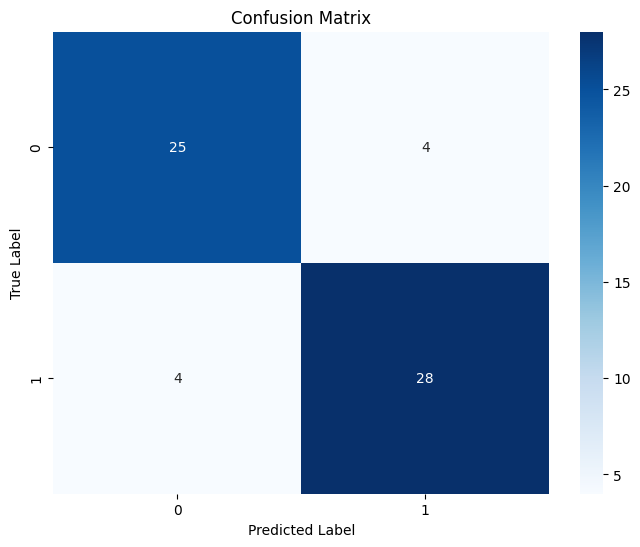

In [56]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tensor.numpy(), y_pred)

# Create a heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [57]:
# Create a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.numpy(), y_pred))


              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        29
         1.0       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

